In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Load MNIST dataset and preprocess
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 64
EPOCHS = 100
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create a Generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(NOISE_DIM,)))  # Use Input instead of input_shape
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Create a Discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(28, 28, 1)))  # Use Input instead of input_shape
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Create the generator and discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()

# Save generated images for visualization
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()  # Add this line to display images inline
    print(f"Image generated and saved for epoch {epoch}.")

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Save images at specific epochs
        if epoch + 1 in [10, 50, 100]:
            generate_and_save_images(generator, epoch + 1, seed)

        # Display epoch progress
        print(f"Epoch {epoch + 1}/{epochs} completed in {time.time() - start:.2f} seconds")



Epoch 1/100 completed in 25.76 seconds
Epoch 2/100 completed in 13.65 seconds
Epoch 3/100 completed in 13.80 seconds
Epoch 4/100 completed in 13.96 seconds
Epoch 5/100 completed in 14.71 seconds
Epoch 6/100 completed in 14.23 seconds
Epoch 7/100 completed in 14.37 seconds
Epoch 8/100 completed in 14.32 seconds
Epoch 9/100 completed in 14.24 seconds


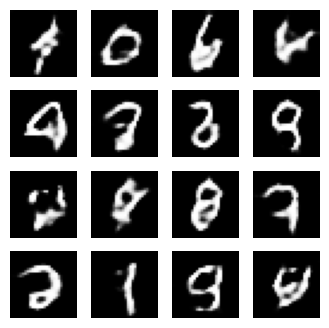

Image generated and saved for epoch 10.
Epoch 10/100 completed in 15.26 seconds
Epoch 11/100 completed in 14.25 seconds
Epoch 12/100 completed in 14.25 seconds
Epoch 13/100 completed in 14.27 seconds
Epoch 14/100 completed in 14.26 seconds
Epoch 15/100 completed in 14.24 seconds
Epoch 16/100 completed in 14.23 seconds
Epoch 17/100 completed in 14.28 seconds
Epoch 18/100 completed in 14.30 seconds
Epoch 19/100 completed in 14.24 seconds
Epoch 20/100 completed in 14.25 seconds
Epoch 21/100 completed in 14.25 seconds
Epoch 22/100 completed in 14.26 seconds
Epoch 23/100 completed in 14.25 seconds
Epoch 24/100 completed in 14.28 seconds
Epoch 25/100 completed in 14.25 seconds
Epoch 26/100 completed in 14.26 seconds
Epoch 27/100 completed in 14.25 seconds
Epoch 28/100 completed in 14.23 seconds
Epoch 29/100 completed in 14.22 seconds
Epoch 30/100 completed in 14.22 seconds
Epoch 31/100 completed in 14.28 seconds
Epoch 32/100 completed in 14.25 seconds
Epoch 33/100 completed in 14.23 seconds


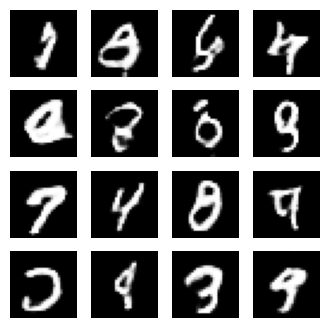

Image generated and saved for epoch 50.
Epoch 50/100 completed in 14.65 seconds
Epoch 51/100 completed in 14.29 seconds
Epoch 52/100 completed in 14.25 seconds
Epoch 53/100 completed in 14.23 seconds
Epoch 54/100 completed in 14.23 seconds
Epoch 55/100 completed in 14.24 seconds
Epoch 56/100 completed in 14.30 seconds
Epoch 57/100 completed in 14.27 seconds
Epoch 58/100 completed in 14.26 seconds
Epoch 59/100 completed in 20.46 seconds
Epoch 60/100 completed in 14.32 seconds
Epoch 61/100 completed in 14.33 seconds
Epoch 62/100 completed in 14.30 seconds
Epoch 63/100 completed in 14.25 seconds
Epoch 64/100 completed in 14.20 seconds
Epoch 65/100 completed in 14.25 seconds
Epoch 66/100 completed in 14.26 seconds
Epoch 67/100 completed in 14.23 seconds
Epoch 68/100 completed in 14.25 seconds
Epoch 69/100 completed in 14.25 seconds
Epoch 70/100 completed in 14.24 seconds
Epoch 71/100 completed in 14.23 seconds
Epoch 72/100 completed in 14.26 seconds
Epoch 73/100 completed in 14.23 seconds


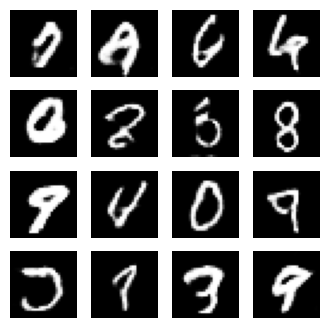

Image generated and saved for epoch 100.
Epoch 100/100 completed in 14.63 seconds


In [4]:
# Train the model
train(train_dataset, EPOCHS)